In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import array
from numpy import newaxis
import math
from scipy import stats
from subprocess import check_output
import seaborn as sns
# from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.recurrent import LSTM
# from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import time #helper libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model


Using TensorFlow backend.


In [13]:
#load your data to train or predict on 
raw_data = pd.read_csv("big_df_adj.csv", low_memory=False)


In [14]:
cols = [c for c in raw_data.columns if c.lower()[-1] == "s"]
df = raw_data[cols]

In [15]:
data_frame = df.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame = data_frame.sort_index(ascending=True, axis=1)
data_frame = data_frame.reindex(index=data_frame.index[::-1])


In [16]:
h = "CME_RB1_FWs"
h[-1]
cols = [c for c in data_frame.columns if c.lower()[-1] == "s"]

In [17]:
a_df = data_frame[cols]


In [11]:
df_z = np.abs(stats.zscore(a_df))
print(df_z)

[[0.53144123 1.70937613 2.04108209 ... 1.00384354 0.92618664 0.92039477]
 [0.54818406 1.73062187 1.88482278 ... 1.04282436 0.96799937 0.96298029]
 [0.48121275 1.67750752 1.84259054 ... 0.98528125 0.87150845 0.88997654]
 ...
 [1.13418309 2.06528362 0.59421    ... 0.60196988 0.03872256 0.14322934]
 [0.97512621 2.00862831 0.59421    ... 0.2938358  0.06766983 0.38353336]
 [0.64864104 2.0829884  0.26479849 ... 0.35137892 0.12852837 0.26388832]]


In [12]:
threshhold = 3
print(np.where(df_z>threshhold))
df_o = a_df[(df_z < threshhold).all(axis=1)]
print(f"Raw Data: {a_df.shape}")
print(f"Data with Z-Scores > {threshhold} removed: {df_o.shape}")

(array([  93,  102,  103,  104,  105,  106,  107,  108,  109,  110,  111,
        112,  113,  114,  115,  116,  117,  118,  120,  245,  246,  247,
        248,  317,  718,  719,  728,  729,  730,  731,  731,  732,  732,
        733,  734,  734,  735,  735,  736,  737,  816,  832,  833,  834,
        925,  928,  933,  961,  962,  963,  964,  965,  966,  969,  970,
        972, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1094,
       1095]), array([ 0, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 10, 10, 10, 10,  0, 16, 16,  4,  4,  4,  4, 16,  4, 16, 16,
        4, 16,  4, 16,  4,  4,  0,  5,  5,  5,  0,  0,  0,  4,  4,  4,  4,
        4,  4,  4,  4, 19, 17, 17, 17, 17, 17, 17, 17, 17, 17,  5,  5]))
Raw Data: (1096, 27)
Data with Z-Scores > 3 removed: (1033, 27)


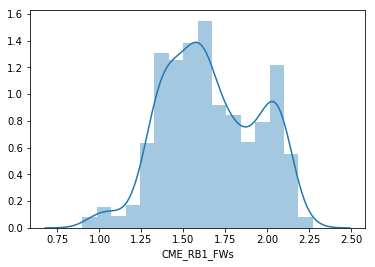

In [18]:
sns.distplot(df_o["CME_RB1_FWs"])

In [19]:
print("Skewness: %f" % df_o["CME_RB1_FWs"].skew())
print("Kurtosis: %f" % df_o['CME_RB1_FWs'].kurt())
print("Skewness: %f" % df_o["CME_RB1_FWs"].skew())
print("Kurtosis: %f" % df_o['CME_RB1_FWs'].kurt())

Skewness: 0.042544
Kurtosis: -0.716245
Skewness: 0.042544
Kurtosis: -0.716245


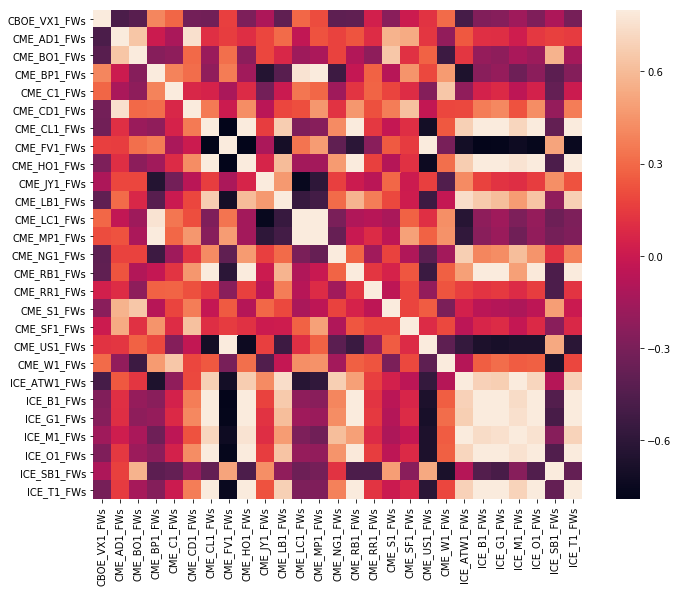

In [20]:
corrmat = df_o.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

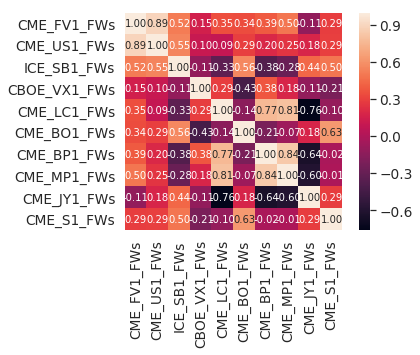

In [21]:
k = 10 #number of variables for heatmap
cols = corrmat.nsmallest(k, 'CME_RB1_FWs')['CME_RB1_FWs'].index
cm = np.corrcoef(a_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

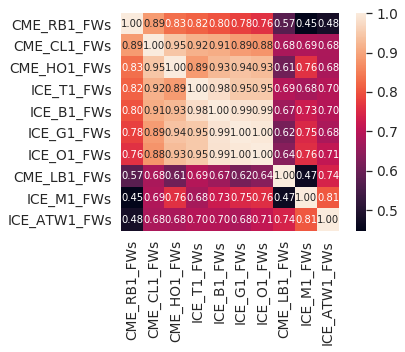

In [22]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'CME_RB1_FWs')['CME_RB1_FWs'].index
cm = np.corrcoef(a_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [28]:
dataset = df_o
dataset = dataset.values
dataset = dataset.astype('float32')
dataset

array([[17.875 ,  0.7001, 26.63  , ...,  2.0436, 11.78  , 61.7   ],
       [17.925 ,  0.6995, 27.    , ...,  2.0562, 11.65  , 62.12  ],
       [17.725 ,  0.701 , 27.1   , ...,  2.0376, 11.95  , 61.4   ],
       ...,
       [17.775 ,  0.807 , 33.76  , ...,  1.9731, 14.91  , 52.916 ],
       [18.725 ,  0.8041, 33.16  , ...,  1.9714, 14.88  , 52.78  ],
       [19.675 ,  0.8067, 32.87  , ...,  1.9137, 14.78  , 51.21  ]],
      dtype=float32)

In [29]:
#scale the data, makes the model happy
np.random.seed(7)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# dataset = scaler
dataset

array([[0.48028672, 0.05069542, 0.04882169, ..., 0.7495387 , 0.12317783,
        0.7069722 ],
       [0.48387086, 0.04578972, 0.07996655, ..., 0.7575565 , 0.1137026 ,
        0.71533865],
       [0.46953404, 0.05805397, 0.08838391, ..., 0.7457207 , 0.1355685 ,
        0.7009961 ],
       ...,
       [0.4731183 , 0.9247751 , 0.6489899 , ..., 0.70467705, 0.35131198,
        0.531992  ],
       [0.54121864, 0.90106297, 0.598485  , ..., 0.7035952 , 0.34912544,
        0.52928287],
       [0.609319  , 0.9223223 , 0.57407403, ..., 0.66687876, 0.34183675,
        0.49800795]], dtype=float32)

In [30]:
#split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


692 341


In [27]:
look_back = 3 # sets how many steps out from the current step model is looking, 3 is two days in our timeseries. The current day and two days out.
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

NameError: name 'create_dataset' is not defined

In [69]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX

array([[[0.48028672],
        [0.48387086],
        [0.46953404],
        ...,
        [0.21146953],
        [0.21505381],
        [0.23297489]],

       [[0.48387086],
        [0.46953404],
        [0.36917567],
        ...,
        [0.21505381],
        [0.23297489],
        [0.24731185]],

       [[0.46953404],
        [0.36917567],
        [0.31541216],
        ...,
        [0.23297489],
        [0.24731185],
        [0.24731185]],

       ...,

       [[0.39068103],
        [0.36200714],
        [0.33906806],
        ...,
        [0.36917567],
        [0.35483873],
        [0.36200714]],

       [[0.36200714],
        [0.33906806],
        [0.33906806],
        ...,
        [0.35483873],
        [0.36200714],
        [0.36200714]],

       [[0.33906806],
        [0.33906806],
        [0.3297491 ],
        ...,
        [0.36200714],
        [0.36200714],
        [0.39784944]]], dtype=float32)

In [50]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(500, input_shape=(look_back, 1)))
model.add(Dense(225))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=15, verbose=2)


Epoch 1/100
 - 4s - loss: 0.0060
Epoch 2/100
 - 2s - loss: 0.0027
Epoch 3/100
 - 2s - loss: 0.0025
Epoch 4/100
 - 2s - loss: 0.0020
Epoch 5/100
 - 2s - loss: 0.0021
Epoch 6/100
 - 2s - loss: 0.0021
Epoch 7/100
 - 2s - loss: 0.0018
Epoch 8/100
 - 2s - loss: 0.0020
Epoch 9/100
 - 2s - loss: 0.0019
Epoch 10/100
 - 2s - loss: 0.0018
Epoch 11/100
 - 2s - loss: 0.0020
Epoch 12/100
 - 2s - loss: 0.0019
Epoch 13/100
 - 2s - loss: 0.0022
Epoch 14/100
 - 2s - loss: 0.0018
Epoch 15/100
 - 2s - loss: 0.0019
Epoch 16/100
 - 2s - loss: 0.0020
Epoch 17/100
 - 2s - loss: 0.0020
Epoch 18/100
 - 2s - loss: 0.0018
Epoch 19/100
 - 2s - loss: 0.0020
Epoch 20/100
 - 2s - loss: 0.0019
Epoch 21/100
 - 2s - loss: 0.0017
Epoch 22/100
 - 2s - loss: 0.0021
Epoch 23/100
 - 2s - loss: 0.0017
Epoch 24/100
 - 2s - loss: 0.0021
Epoch 25/100
 - 2s - loss: 0.0019
Epoch 26/100
 - 2s - loss: 0.0019
Epoch 27/100
 - 2s - loss: 0.0020
Epoch 28/100
 - 2s - loss: 0.0018
Epoch 29/100
 - 2s - loss: 0.0020
Epoch 30/100
 - 2s - lo

In [51]:
model.save('multilstm.h5') #change file name! lstm_modelCLstep15, lstm_modelCL

In [300]:
model = load_model('multilstm.h5') #load a model 

In [84]:
# make predictions
trainPredict = model.predict(trainX, verbose=1)
testPredict = model.predict(testX, verbose=1)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

325/325 [==============================] - 0s 353us/step


ValueError: non-broadcastable output operand with shape (676,1) doesn't match the broadcast shape (676,27)

In [ ]:
CME_RB1_FWs

In [138]:
close_fft = np.fft.fft(np.asarray(data_FT['GS'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

[] []


In [143]:
data_FT = raw_data[['CME_RB1_FWd', "CME_RB1_FWs"]]

In [145]:
close_fft = np.fft.fft(np.asarray(data_FT['CME_RB1_FWs'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


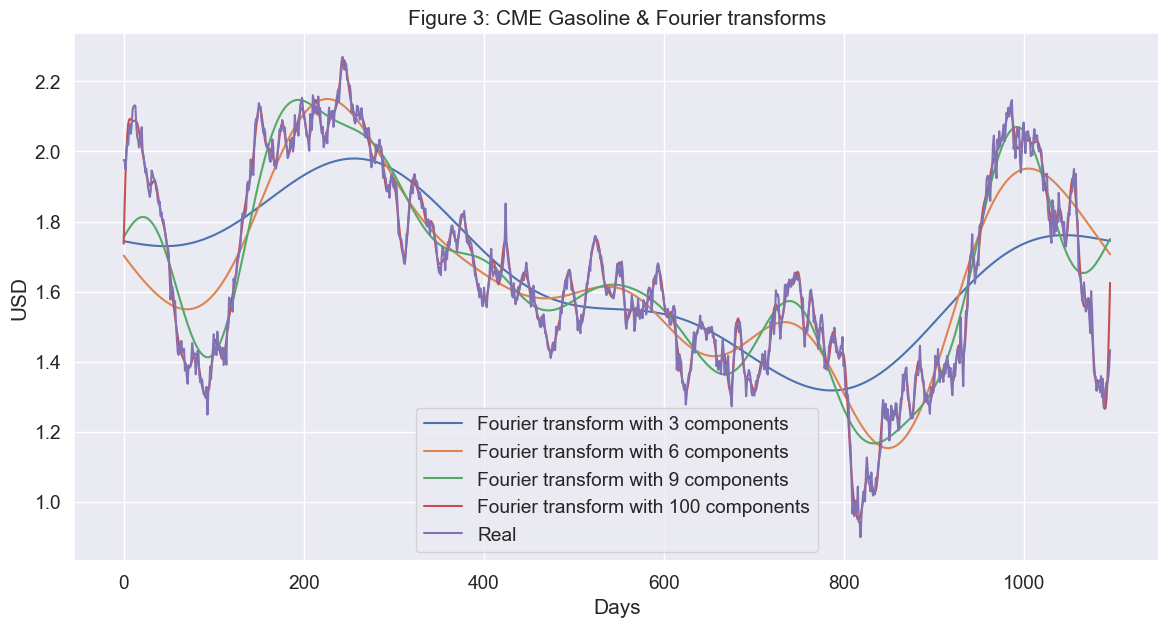

<Figure size 432x288 with 0 Axes>

In [149]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['CME_RB1_FWs'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: CME Gasoline & Fourier transforms')
plt.legend()
plt.show()
plt.savefig('./img/CME_RB1_FWs_FT.png')

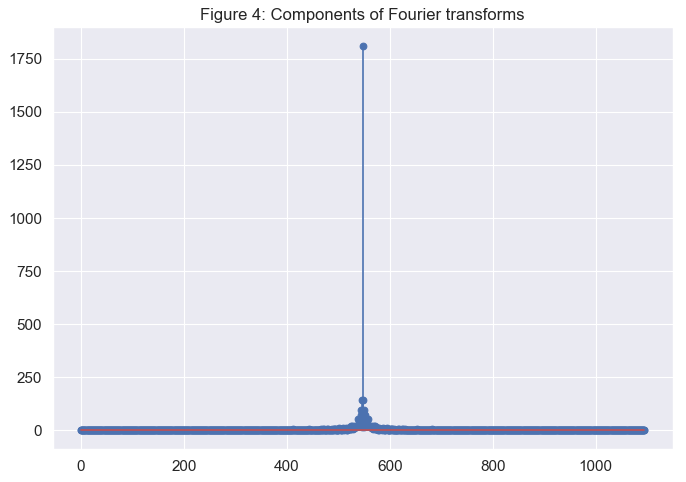

In [152]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [153]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['CME_RB1_FWs']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidime

                             ARIMA Model Results                              
Dep. Variable:          D.CME_RB1_FWs   No. Observations:                 1095
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2127.402
Method:                       css-mle   S.D. of innovations              0.035
Date:                Tue, 14 May 2019   AIC                          -4240.803
Time:                        18:05:18   BIC                          -4205.814
Sample:                             1   HQIC                         -4227.563
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0005      0.001     -0.441      0.660      -0.003       0.002
ar.L1.D.CME_RB1_FWs    -0.0282      0.030     -0.932      0.351      -0.087       0.031
ar.L2.D.CME_RB1_

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


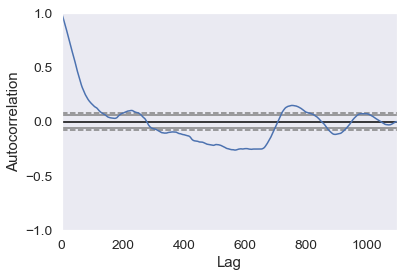

<Figure size 800x560 with 0 Axes>

In [154]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [157]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = raw_data["CME_RB1_FWs"].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidime

In [158]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.002


In [1]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on Gasolinestock')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [178]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], df.shape[1]))

Total dataset has 1096 samples, and 27 features.


In [228]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['CME_RB1_FWs']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [229]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df)


In [230]:
df.columns

Index(['CBOE_VX1_FWs', 'CME_US1_FWs', 'CME_FV1_FWs', 'CME_C1_FWs',
       'CME_RR1_FWs', 'CME_BO1_FWs', 'CME_S1_FWs', 'CME_W1_FWs', 'CME_AD1_FWs',
       'CME_BP1_FWs', 'CME_CD1_FWs', 'CME_JY1_FWs', 'CME_LC1_FWs',
       'CME_MP1_FWs', 'CME_LB1_FWs', 'CME_SF1_FWs', 'ICE_B1_FWs', 'ICE_G1_FWs',
       'ICE_O1_FWs', 'ICE_ATW1_FWs', 'ICE_SB1_FWs', 'ICE_M1_FWs', 'ICE_T1_FWs',
       'CME_NG1_FWs', 'CME_CL1_FWs', 'CME_RB1_FWs', 'CME_HO1_FWs'],
      dtype='object')

In [231]:
import xgboost as xgb

In [232]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [233]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], verbose=False)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [234]:
eval_result = regressor.evals_result()

In [235]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

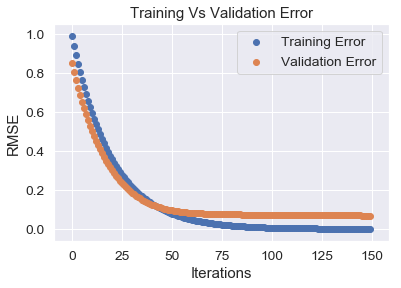

In [236]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

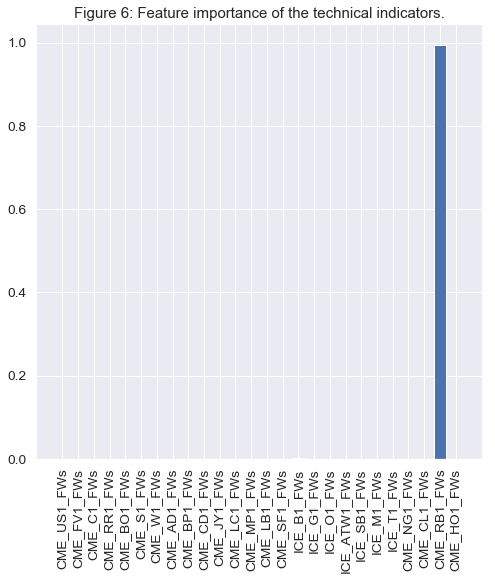

In [237]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()